# AIsteroid
[http://bit.ly/aisteroid](http://bit.ly/aisteroid)

In [1]:
from aisteroid import *
%matplotlib nbagg

## Task: Sky View

### Choose the image set

In [2]:
if QIPY:
    #listImages() ##See the list of imagesets
    #CONF.CFG="example" ##You choose your preferred observatory configuration (example.cfg)
    CONF.OVERWRITE=1 ##Overwrite all previous actions
    CONF.VERBOSE=1 ## Show all outputs
    CONF.SET="example" ##Choose your preferred imageset
    #CONF.SET='ps1-20180107_1_set077'

#### DO NOT TOUCH IF YOU ARE NOT SURE

In [3]:
#DO NOT MODIFY THIS LINES
print0("*"*60+"\nSKY VIEW OF '%s'\n"%CONF.SET+"*"*60)

OUT_DIR=CONF.SCR_DIR+CONF.SET+"/"
if not os.path.isdir(OUT_DIR):
    error("Set '%s' has not been unpacked"%CONF.SET)

CFG=[line.rstrip('\n') for line in open(CONF.SETS_DIR+CONF.CFG+".cfg")]

PLOT_DIR=OUT_DIR+"plots/"
FLOG=open(OUT_DIR+"astrometria.log","a")
SYSOPTS=dict(qexit=[True,FLOG])

AIA_FILE=OUT_DIR+CONF.SET+".aia"
if not os.path.isfile(AIA_FILE):
    error("Detect task not ran yet on set '%s'"%CONF.SET)
else:
    AIA=pickle.load(open(AIA_FILE,"rb"))
    images=AIA["images"]
    sources=AIA["sources"]
    detector=AIA["detector"]
    nimgs=len(images)

************************************************************
SKY VIEW OF 'example'
************************************************************


### Find transformation from image coordinates to sky coordinates

In [4]:
#Fint transformation from x,y to RA,DEC
print0("Transforming from image coordinates to sky coordinates:")
tr=AffineTransform()
bright=sources[sources.MAG_ASTRO<20]
status=tr.estimate(bright[["X_IMAGE","Y_IMAGE"]].values,
                   bright[["RA","DEC"]].values)

#Test transformation
print0("\tTesting transformation:")
imxy=sources.iloc[0][["X_IMAGE","Y_IMAGE"]].values
skrd=sources.iloc[0][["RA","DEC"]].values
skrdt=tr(imxy)
print1("\t\tCoordinates before transformation:",skrd)
print1("\t\tCoordinates after transformation:",skrdt)
dif=np.linalg.norm(skrdt-skrd)
print0("\t\tError (arcsec):",dif/ARCSEC)

#Averaging
ds=tr(sources[["X_IMAGE","Y_IMAGE"]].values)-sources[["RA","DEC"]].values
ds=np.array([np.linalg.norm(ds[i]) for i in range(ds.shape[0])])
print("\tAverage error (ARCSEC):",ds.mean()/ARCSEC)

Transforming from image coordinates to sky coordinates:
	Testing transformation:
		Coordinates before transformation: [ 315.96373132  -15.5259403 ]
		Coordinates after transformation: [[ 315.96389768  -15.52593669]]
		Error (arcsec): 0.599048830576
	Average error (ARCSEC): 0.829513256913


### View the Image

<IPython.core.display.Javascript object>


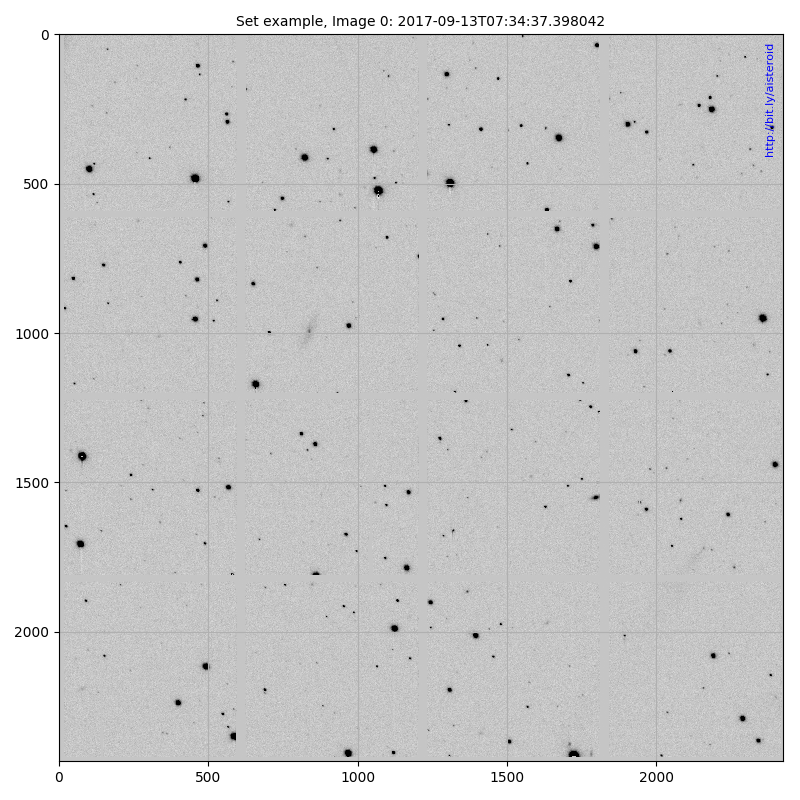

In [5]:
plt.ion() ##Comment to see interactive figure

#Basic figure
fig=plt.figure(figsize=(8,8))
ax=fig.gca()
imgargs=dict(cmap='gray_r',vmin=0,vmax=700)
im=plt.imshow(images[0]["data"],animated=True,**imgargs)
tm=plt.title("Set %s, Image 0: "%CONF.SET+images[0]["obstime"],fontsize=10)
RECT=pat.Rectangle([0,0],0,0,color='r',fc='None')
ax.add_patch(RECT)
waterMark(fig.gca())
plt.grid()
fig.tight_layout()

def updatefig(i):
    iimg=i%nimgs
    im.set_array(images[iimg]["data"])
    tm.set_text("Set %s, Image %d: "%(CONF.SET,iimg)+images[iimg]["obstime"])
    return im,

#Create animation
ani=animation.FuncAnimation(fig,updatefig,frames=range(nimgs),
                            interval=1000,repeat_delay=1000,
                            repeat=True,blit=True)

In [69]:
#Write here the coordinates X and Y of the point around which you want a sky view
X = 2080
Y = 1560

#Give also the width and height of the region
WIDTH = 500
HEIGH = 500

#Place a rectange
RECT.set_xy([X-WIDTH/2.,Y-HEIGH/2.])
RECT.set_width(WIDTH)
RECT.set_height(HEIGH)

#Compute coordinates
p=tr([X,Y])[0]
RA=dec2sex(p[0]/15,"string",":")
DEC=dec2sex(p[1],"string",":")
print("Sky coordinates: RA = %s, DEC = %s"%(RA,DEC))

Sky coordinates: RA = 21:04:7.48, DEC = -15:31:0.90


### Get the Sky View Region

In [77]:
img = SkyView.get_images(position='%s,%s'%(RA,DEC),
                         survey=['DSS2 Red'],
                         pixels='%d,%d'%(WIDTH,HEIGH),
                         width=Angle(WIDTH*detector.PXSIZE,"deg"),
                         height=Angle(HEIGH*detector.PXSIZE,"deg"),
                         coordinates='J2000',grid=True,gridlabels=True)

### Show image

<IPython.core.display.Javascript object>


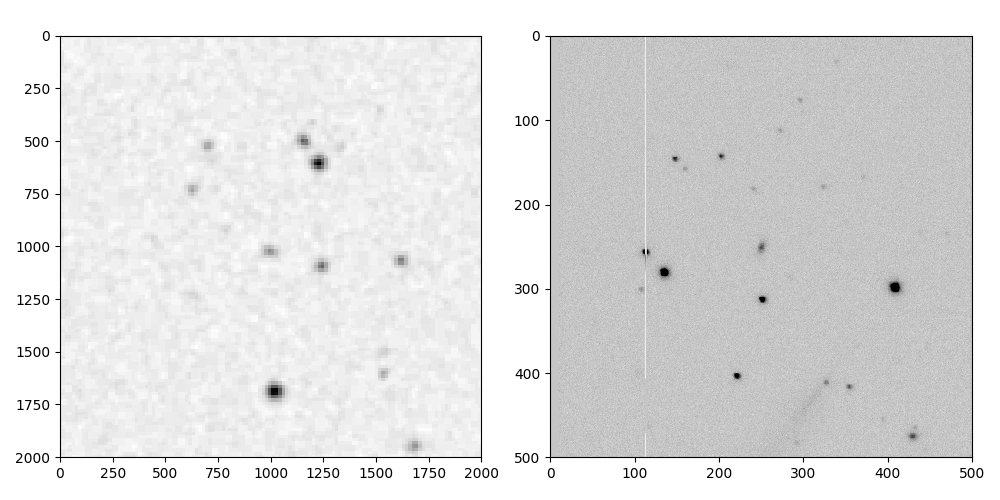

In [75]:
fig,axs=plt.subplots(1,2,figsize=(10,5))
subimg=images[0]["data"][int(Y-HEIGH/2):int(Y+HEIGH/2),int(X-WIDTH/2):int(X+WIDTH/2)]

axs[0].imshow(img[0][0].data,cmap="gray_r")
axs[1].imshow(subimg,**imgargs)

fig.tight_layout()